In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json, os
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import mixed_precision
from tensorflow.keras.applications.efficientnet import preprocess_input

In [ ]:
mixed_precision.set_global_policy('mixed_float16')

In [3]:
IMG_SIZE = (160,160)
BATCH_SIZE = 32
DATA_DIR = "data"

train_ds = image_dataset_from_directory(
  DATA_DIR + "/Train",
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE,
  seed=42
)

test_ds = image_dataset_from_directory(
  DATA_DIR + "/Test",
  image_size = IMG_SIZE,
  batch_size = BATCH_SIZE,
  seed = 42
)

class_names = train_ds.class_names
print("Number of classes:", len(class_names))
print(class_names)

val_size = 0.1
val_batches = int(len(train_ds) * val_size)
val_ds = train_ds.take(val_batches)  
train_ds = train_ds.skip(val_batches)

Found 43429 files belonging to 38 classes.
Found 10876 files belonging to 38 classes.
Number of classes: 38
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Lea

In [4]:
len(test_ds)

340

In [5]:
# normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
])

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(lambda x,y : (data_augmentation(x),y)).map(lambda x, y: (preprocess_input(x), y))
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))
test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y))

train_ds = train_ds.shuffle(buffer_size=600).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Cause: could not parse the source code of <function <lambda> at 0x000002591FDBA790>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x, y: (preprocess_input(x), y)

Match 1:
lambda x, y: (data_augmentation(x), y)

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x000002591FDBA790>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x, y: (preprocess_input(x), y)

Match 1:
lambda x, y: (data_augmentation(x), y)

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <funct

In [6]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers,models,optimizers

IMG_SIZE = (160,160)
NUM_CLASSES = len(class_names)

base_model = EfficientNetB0(
  include_top = False,
  weights = 'imagenet',
  input_shape = IMG_SIZE + (3,)
)

base_model.trainable = False

In [7]:
model = models.Sequential([
  base_model,
  layers.GlobalAveragePooling2D(),
  layers.Dropout(0.3),
  layers.Dense(NUM_CLASSES,activation='softmax')
])

model.compile(
  optimizer = optimizers.Adam(learning_rate=0.001),
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 5, 5, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 38)                48678     
                                                                 
Total params: 4,098,249
Trainable params: 48,678
Non-trainable params: 4,049,571
_________________________________________________________________


In [8]:
EPOCHS = 10
history = model.fit(train_ds,epochs=EPOCHS,validation_data = val_ds,verbose=1)

Epoch 1/10
1223/1223 [==============================] - 176s 104ms/step - loss: 0.8221 - accuracy: 0.7895 - val_loss: 0.5110 - val_accuracy: 0.8551
Epoch 2/10
1223/1223 [==============================] - 100s 82ms/step - loss: 0.3833 - accuracy: 0.8899 - val_loss: 0.3993 - val_accuracy: 0.8836
Epoch 3/10
1223/1223 [==============================] - 103s 84ms/step - loss: 0.3075 - accuracy: 0.9072 - val_loss: 0.3532 - val_accuracy: 0.8940
Epoch 4/10
1223/1223 [==============================] - 107s 88ms/step - loss: 0.2762 - accuracy: 0.9159 - val_loss: 0.3428 - val_accuracy: 0.8954
Epoch 5/10
1223/1223 [==============================] - 106s 87ms/step - loss: 0.2460 - accuracy: 0.9245 - val_loss: 0.3181 - val_accuracy: 0.9032
Epoch 6/10
1223/1223 [==============================] - 102s 83ms/step - loss: 0.2345 - accuracy: 0.9257 - val_loss: 0.3276 - val_accuracy: 0.8965
Epoch 7/10
1223/1223 [==============================] - 101s 83ms/step - loss: 0.2241 - accuracy: 0.9291 - val_loss: 

In [19]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [16]:
model.save_weights("models/crop_disease_weights.h5")

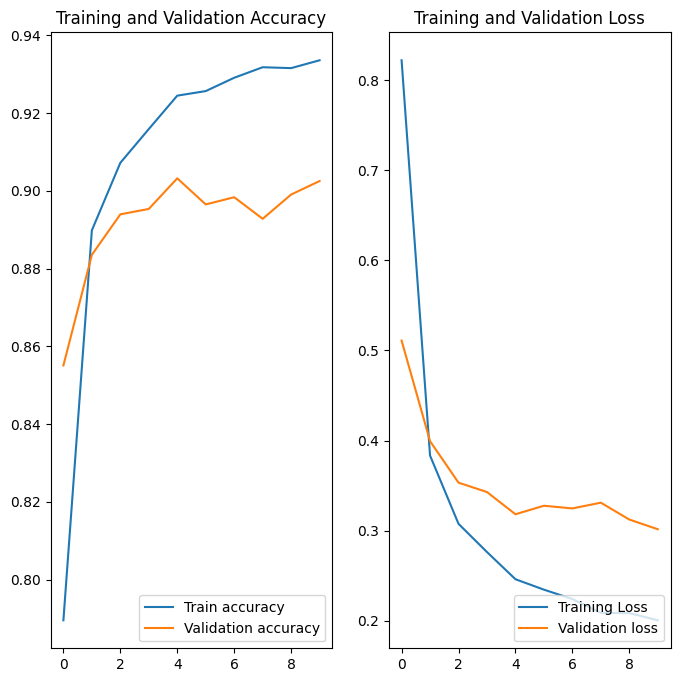

In [21]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),history.history['accuracy'],label='Train accuracy')
plt.plot(range(EPOCHS),history.history['val_accuracy'],label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),history.history['loss'],label='Training Loss')
plt.plot(range(EPOCHS),history.history['val_loss'],label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend(loc='lower right')
plt.show()

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

In [24]:
early_stop = EarlyStopping(
  monitor='val_loss',
  patience=5,
  restore_best_weights=True
)

In [25]:
base_model.trainable =True
for layer in base_model.layers[:-20]:
  layer.trainable = False

model.compile(
  optimizer = optimizers.Adam(learning_rate=0.0001),
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
)

history_finetuned = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/20
1223/1223 [==============================] - 133s 104ms/step - loss: 0.2805 - accuracy: 0.9111 - val_loss: 0.2865 - val_accuracy: 0.9109
Epoch 2/20
1223/1223 [==============================] - 105s 86ms/step - loss: 0.1209 - accuracy: 0.9605 - val_loss: 0.2419 - val_accuracy: 0.9257
Epoch 3/20
1223/1223 [==============================] - 110s 90ms/step - loss: 0.0736 - accuracy: 0.9759 - val_loss: 0.2326 - val_accuracy: 0.9301
Epoch 4/20
1223/1223 [==============================] - 105s 86ms/step - loss: 0.0551 - accuracy: 0.9822 - val_loss: 0.2120 - val_accuracy: 0.9331
Epoch 5/20
1223/1223 [==============================] - 109s 89ms/step - loss: 0.0397 - accuracy: 0.9877 - val_loss: 0.1920 - val_accuracy: 0.9396
Epoch 6/20
1223/1223 [==============================] - 113s 93ms/step - loss: 0.0305 - accuracy: 0.9908 - val_loss: 0.1896 - val_accuracy: 0.9447
Epoch 7/20
1223/1223 [==============================] - 109s 89ms/step - loss: 0.0248 - accuracy: 0.9923 - val_loss: 

In [26]:
model.save_weights("models/crop_disease_weights_finedtuned.h5")

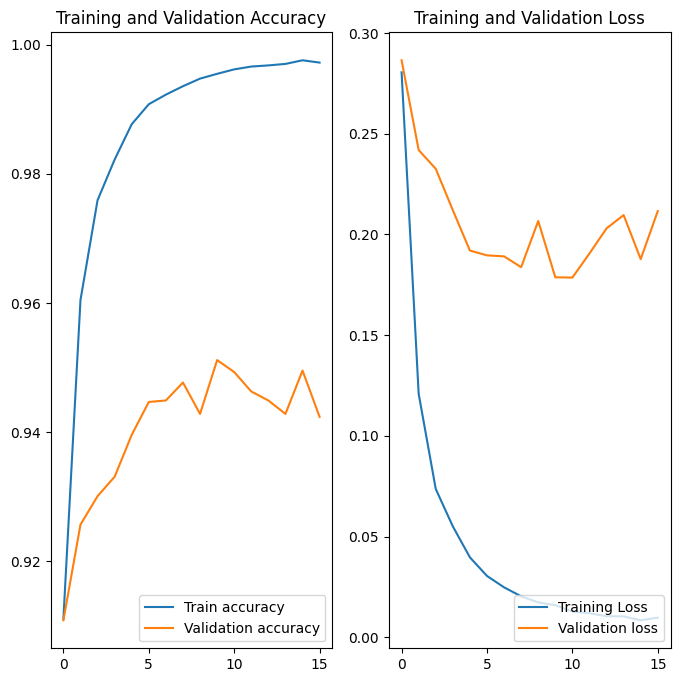

In [30]:
epochs_ran = len(history_finetuned.history['accuracy'])

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs_ran),history_finetuned.history['accuracy'],label='Train accuracy')
plt.plot(range(epochs_ran),history_finetuned.history['val_accuracy'],label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(range(epochs_ran),history_finetuned.history['loss'],label='Training Loss')
plt.plot(range(epochs_ran),history_finetuned.history['val_loss'],label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend(loc='lower right')
plt.show()

In [33]:
test_loss , test_acc = model.evaluate(test_ds)
print(f"Test Accuracy : {test_acc*100:.2f}%")
print(f"Test Loss : {test_loss:.2f}")

340/340 [==============================] - 25s 74ms/step - loss: 0.2169 - accuracy: 0.9442
Test Accuracy : 94.42%
Test Loss : 0.22


Actual label :  Grape___Esca_(Black_Measles)
1/1 [==============================] - 0s 315ms/step
Predicted label :  Grape___Esca_(Black_Measles)


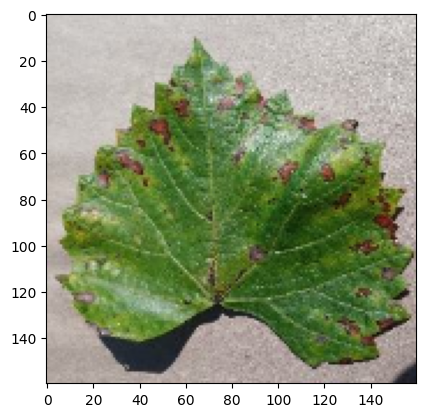

In [40]:
for images_batch,labels_batch in test_ds.take(1):
  first_img = images_batch[23].numpy().astype('uint8')
  first_label = labels_batch[23].numpy()

  plt.imshow(first_img)
  print("Actual label : ",class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print("Predicted label : ",class_names[np.argmax(batch_prediction[23])])

In [46]:
def predict(model,img):
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array,0)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence  = round(100 * np.max(predictions[0]),2)

  return predicted_class,confidence

1/1 [==============================] - 0s 75ms/step


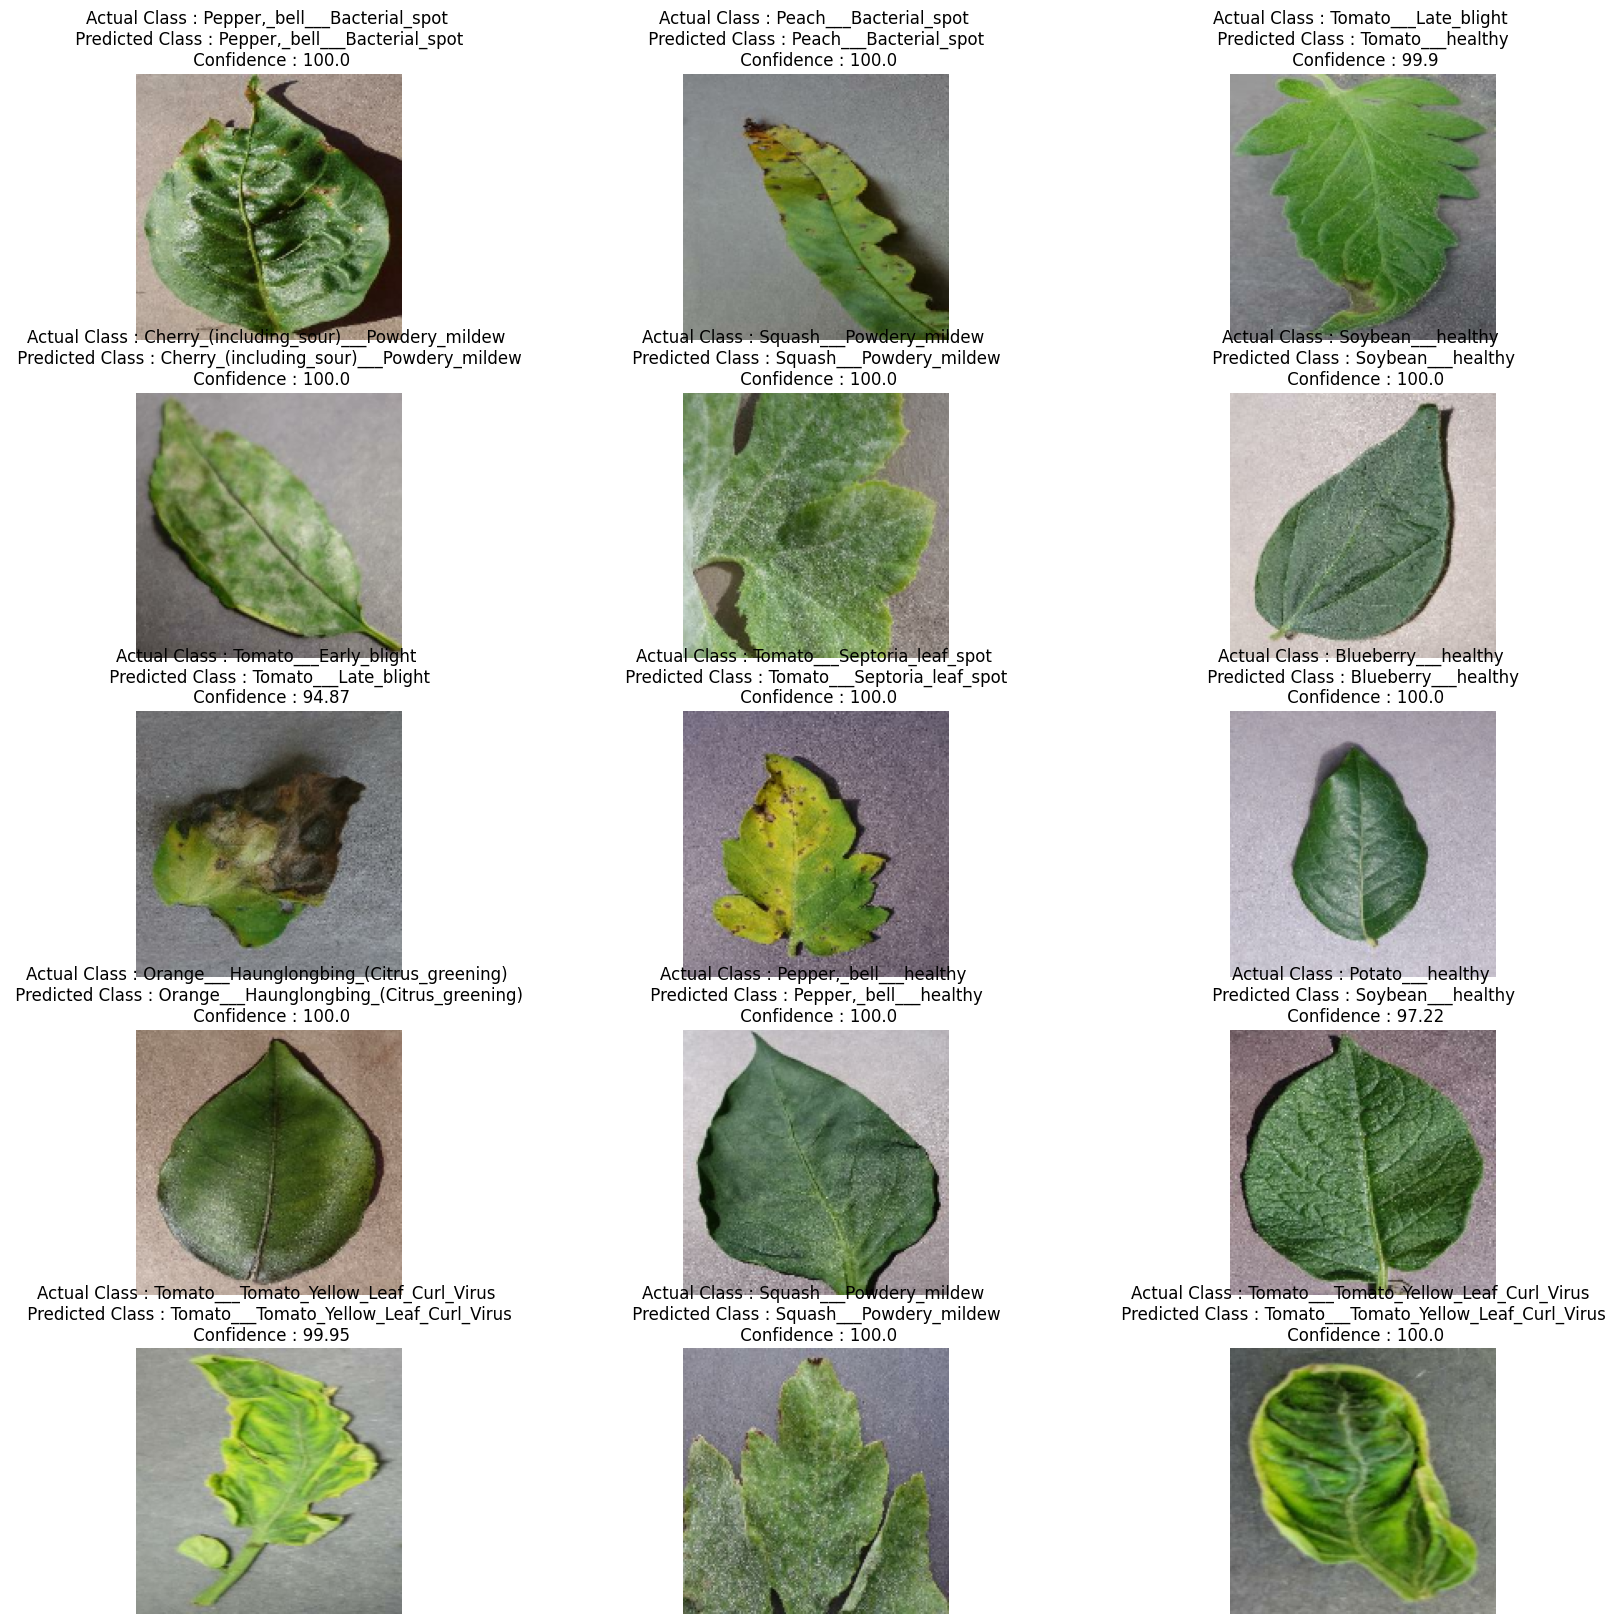

In [52]:
plt.figure(figsize=(20,20))
for images,labels in test_ds.take(18):
  for i in range(15):
    ax = plt.subplot(5,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    predicted_class,confidence = predict(model,images[i].numpy())
    actual_class = class_names[labels[i]]
    plt.title(f"Actual Class : {actual_class} \n Predicted Class : {predicted_class} \n Confidence : {confidence}")
    plt.axis("off")